# ImageNet-Patch: A Dataset for Benchmarking Machine Learning Robustness against Adversarial Patches
Preprint Paper: https://arxiv.org/pdf/2203.04412.pdf

## Clone Repo

In [2]:
try:
    from transforms.apply_patch import ApplyPatch
except:
    # clone the repository
    !git clone https://github.com/pralab/ImageNet-Patch
    %cd ImageNet-Patch/

C:\Users\ivanr\Apps\machine-learning-projects\ml-adversarial-robustness\ImageNet-Patch


Cloning into 'ImageNet-Patch'...


## Loading Data

In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import torchvision.models as models
from utils.utils import set_all_seed
from utils.utils import target_transforms
from transforms.apply_patch import ApplyPatch
import gzip
import pickle
import os

set_all_seed(42)

# dictionary with the ImageNet label names
with open(os.path.join(os.getcwd(), "assets/imagenet1000_clsidx_to_labels.txt")) as f:
    target_to_classname = eval(f.read())

## **Import Imagenet-Patch**

The set of patches within the related information is saved in a tuple that contains three elements:


1. **patches**: tensor with shape $(10, 3, 224, 224)$ containing all the ten pre-optimized patch;
2. **targets**: tensor with shape $(10,)$ containing the target class of each patch;
3. **info**: a dictionary containing the input shape of the images that has been used to optimize the patches, the type of the patch, which in this case is sqared, the size of the patch measured in number of pixels (considering the length of the square's size) and a dictionary that map the target label to the corresponding class name.

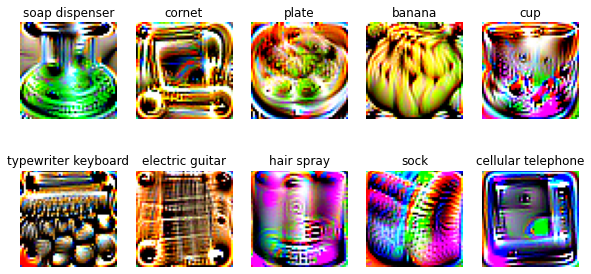

In [5]:
# Load the patches
with gzip.open(os.path.join(os.getcwd(), "assets/imagenet_patch.gz"), 'rb') as f:
    imagenet_patch = pickle.load(f)
    
patches, targets, info = imagenet_patch

from utils.visualization import show_imagenet_patch
show_imagenet_patch(patches, targets)

A single patch can be selected indexing the obtained tensor through its ID, with the following mapping:

0. soap dispenser
1. cornet
2. plate
3. banana
4. cup
5. typewriter keyboard
6. electric guitar
7. hair spray
8. sock
9. cellular telephone

## **Apply the patch to the images**

Once ImageNet-Patch is loaded and a single patch is selected, you can instantiate the `ApplyPatch` module, specifying the patch tensor, the patch size, and the ranges from which the parameters of the transformation will be randomly sampled from a uniform distribution.
In particular the available transformations are the following:



1. `translation_range`: indicates the translation fraction with respect to the image dimensions $(Δx, Δy)$, e.g. $(0.1, 0.2)$ will move the patch $±22.4$ pixels in the first dimension and $±44.8$ in the second one;
2. `rotation_range`: indicates the minimum and maximum angle for the patch rotation $(θ_{min}, θ_{max})$;
3. `scale_range`: indicates the minimum and maximum ratio between the scaled dimensions and the original ones $(s_{min}, s_{max})$.

After the `ApplyPatch` module is instantiated, you can feed to it a batch of images just before the `Normalize` module.


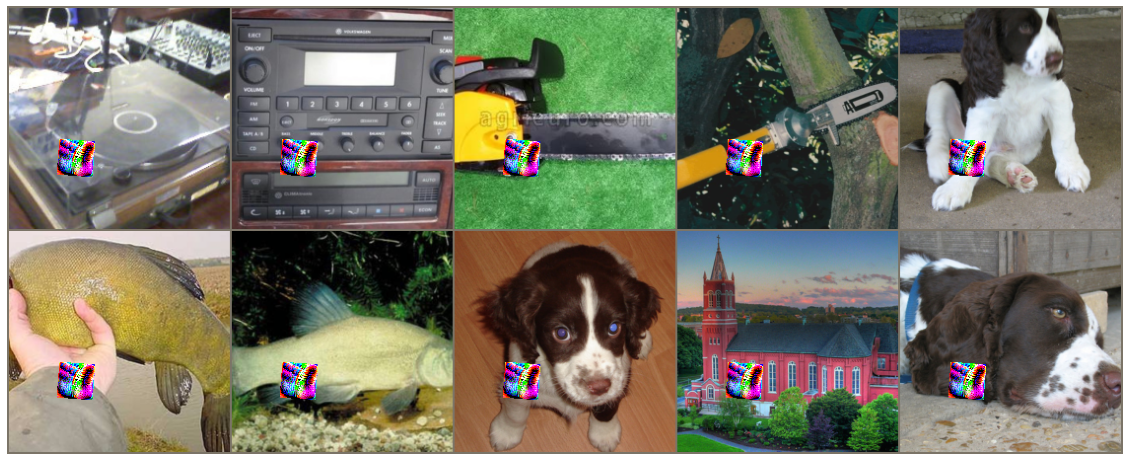

In [14]:
# Choose an integer in the range 0-9 to select the patch
patch_id = 8
patch = patches[patch_id]      # get the chosen patch
target = targets[patch_id]

# Instantiate the ApplyPatch module setting the patch and the affine transformation that will be applied
apply_patch = ApplyPatch(patch, patch_size=info['patch_size'],
                         translation_range=(.2, .2),
                         rotation_range=(-45, 45),
                         scale_range=(0.7, 1)           # scale range wrt image dimensions
                         )

# For convenience the preprocessing steps are splitted to compute also the clean predictions
normalizer = Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
patch_normalizer = Compose([apply_patch, normalizer])

# Load the data
preprocess = Compose([Resize(256), CenterCrop(224), ToTensor()])    # ensure images are 224x224
dataset = ImageFolder(os.path.join(os.getcwd(), "assets/data"),
                      transform=preprocess,
                      target_transform=target_transforms)

data_loader = DataLoader(dataset, batch_size=10, shuffle=True)
x, y = next(iter(data_loader))  # load a mini-batch
x_clean = normalizer(x)
x_adv = patch_normalizer(x)

from utils.visualization import show_batch_with_patch
show_batch_with_patch(x_adv, transforms=patch_normalizer, figsize=(20, 10))

## Test the patch on AlexNet

Now you can collect the predictions assigned by the classifier to the perturbed images.

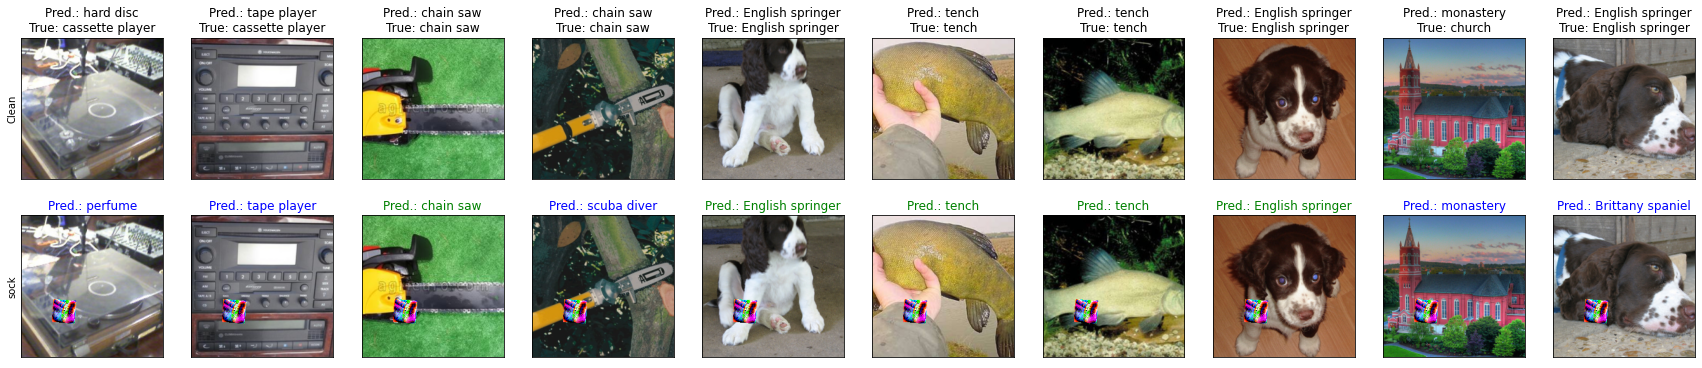

In [15]:
# Load model
model = models.alexnet(pretrained=True)
model.eval()

# Feed the model with the clean images
output_clean = model(x_clean)
clean_predictions = torch.argmax(output_clean, dim=1).cpu().detach().numpy()

# Feed the model with the images corrupted by the patch
output_adv = model(x_adv)
adv_predictions = torch.argmax(output_adv, dim=1).cpu().detach().numpy()

from utils.visualization import plot_patch_predictions
plot_patch_predictions(x_clean, x_adv, clean_predictions, adv_predictions,
                       true_label=y.cpu().detach().numpy(), target=int(target.item()),
                       figsize=(30, 6), normalizer=normalizer)

## **Measuring a Model's Performance against Imagenet-Patch**

The evaluation of a model follows the classical PyTorch framework, with the only difference that you have to feed the batch of images to `ApplyPatch` and `Normalize`.

In [16]:
correct_clean = 0
correct_adv = 0
n_success = 0
n_samples = 0
set_all_seed(42)

with torch.no_grad():
    for x,y in data_loader:
#         if torch.cuda.is_available():
#             x = x.cuda()
#             y = y.cuda()

        x_clean = normalizer(x)
        x_adv = patch_normalizer(x)

        pred_clean = model(x_clean)
        correct_clean += (pred_clean.argmax(1) == y).sum().item()

        pred_adv = model(x_adv)
        correct_adv += (pred_adv.argmax(1) == y).sum().item()
        n_success += (pred_adv.argmax(1) == target).sum().item()

        n_samples += x.shape[0]

clean_accuracy = 100*(correct_clean / n_samples)
robust_accuracy = 100*(correct_adv / n_samples)
success_rate = 100*(n_success / n_samples)

print(f"Clean accuracy: {clean_accuracy:>0.1f}%")
print(f"Robust accuracy: {robust_accuracy:>0.1f}%")
print(f"Success rate: {success_rate:>0.1f}%")

Clean accuracy: 64.0%
Robust accuracy: 18.0%
Success rate: 8.0%
